In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df_names = ['71573414','71873225','72223414','72233225','72271608','72283414']
fife_dfs = []

for i in range(len(df_names)):
    df = pd.read_csv(f'../data/fife_data/{df_names[i]}.psl')
                     
    df = df[['PAR_DOWN','CHAMBER_TEMP','CHAMBER_CO2_CONTENT','PHOTOSYN_RATE']]
    fife_dfs.append(df)

fife_df = pd.concat(fife_dfs, ignore_index=True)
print(fife_df)

      PAR_DOWN  CHAMBER_TEMP  CHAMBER_CO2_CONTENT  PHOTOSYN_RATE
0       1008.0          28.2                325.0           10.1
1       1011.0          28.3                323.0           11.7
2       1011.0          28.4                321.0           10.1
3       1021.0          29.6                276.0           11.9
4       1021.0          29.6                275.0           11.3
...        ...           ...                  ...            ...
1199    1582.0          39.8                321.0           21.5
1200    1579.0          39.9                297.0           21.7
1201    1570.0          40.5                346.0           22.9
1202    1569.0          40.6                321.0           21.5
1203       NaN           NaN                  NaN            NaN

[1204 rows x 4 columns]


In [3]:
weather_data = pd.read_csv('../data/CRNHE0101-NC_Asheville_8_SSW.csv', index_col='DATE_TIME')
global_irrad = weather_data['SOLAR_RADIATION'].dropna()

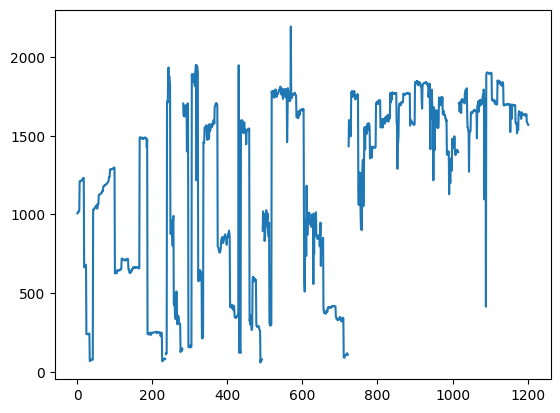

In [52]:
plt.plot(fife_df['PAR_DOWN'])

In [57]:
unique_par = np.unique(fife_df['PAR_DOWN'])
prinbt(len(unique_par)/max(unique_par))

0.3173734610123119


In [77]:
print(global_irrad.iloc[1])

28.5


In [89]:
def select_optimal_conditions(fife_df, current_irradiance):
    fife_df['PAR_DIFF'] = abs(fife_df['PAR_DOWN'] - current_irradiance)
    fife_df_sorted = fife_df.sort_values(by='PAR_DIFF')

    return(fife_df_sorted.dropna())

opt_conditions = select_optimal_conditions(fife_df, global_irrad.iloc[1000])

In [92]:
print(opt_conditions.columns)
for i in opt_conditions.values:
    print(i)

Index(['PAR_DOWN', 'CHAMBER_TEMP', 'CHAMBER_CO2_CONTENT', 'PHOTOSYN_RATE',
       'PAR_DIFF'],
      dtype='object')
[ 61.   33.5 426.    1.   61. ]
[ 69.   29.6 328.    2.2  69. ]
[ 70.   30.  320.    2.5  70. ]
[ 70.   29.6 329.    2.4  70. ]
[ 71.   29.7 327.    2.3  71. ]
[ 71.   30.  321.    2.1  71. ]
[ 72.   29.9 322.    2.1  72. ]
[ 74.   31.7 236.    0.9  74. ]
[ 77.   32.2 366.    1.5  77. ]
[ 77.  30. 325.   1.  77.]
[ 78.   29.9 330.    1.6  78. ]
[ 79.   30.  324.    1.1  79. ]
[ 79.  30. 327.   1.  79.]
[ 79.   30.  329.    1.1  79. ]
[ 79.   30.  323.    1.6  79. ]
[ 80.   30.  324.    2.7  80. ]
[ 80.   29.9 325.    2.4  80. ]
[ 80.   32.5 371.    1.6  80. ]
[ 80.   32.7 376.    1.5  80. ]
[ 81.   30.  323.    1.9  81. ]
[ 84.   30.5 308.    2.8  84. ]
[ 85.   30.5 309.    2.7  85. ]
[ 87.   30.4 311.    2.2  87. ]
[ 91.   37.3 350.    1.8  91. ]
[ 92.   37.2 355.    1.7  92. ]
[ 93.   37.1 360.    1.9  93. ]
[102.   38.1 367.    2.4 102. ]
[105.   38.3 361.    2.6 105.

Approach involving using kNN

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

features = fife_df[['PHOTOSYN_RATE', 'CHAMBER_TEMP']]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
photo_rate, chamber_temp = features_scaled.T
fife_df['FIT'] = photo_rate - chamber_temp

print(fife_df)

      PAR_DOWN  CHAMBER_TEMP  CHAMBER_CO2_CONTENT  PHOTOSYN_RATE       FIT
0       1008.0          28.2                325.0           10.1  0.721785
1       1011.0          28.3                323.0           11.7  0.725527
2       1011.0          28.4                321.0           10.1  0.708271
3       1021.0          29.6                276.0           11.9  0.639001
4       1021.0          29.6                275.0           11.3  0.635064
...        ...           ...                  ...            ...       ...
1199    1582.0          39.8                321.0           21.5  0.012804
1200    1579.0          39.9                297.0           21.7  0.007360
1201    1570.0          40.5                346.0           22.9 -0.025307
1202    1569.0          40.6                321.0           21.5 -0.041250
1203       NaN           NaN                  NaN            NaN       NaN

[1204 rows x 5 columns]


In [29]:
def select_conditions_kNN(dataset, irradiance):
    X = dataset[['PAR_DOWN', 'FIT']].dropna()
    nbrs = NearestNeighbors(n_neighbors = 1, algorithm='auto').fit(X)

    target_PAR = np.vstack((irradiance, np.zeros(len(irradiance)))).T

    distance, indices = nbrs.kneighbors(target_PAR)
    return dataset.iloc[indices.flatten()]

results = select_conditions_kNN(fife_df, df['I_glob'])
print(results[['CHAMBER_TEMP', 'CHAMBER_CO2_CONTENT']])

C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


     CHAMBER_TEMP  CHAMBER_CO2_CONTENT
486          33.9                473.0
486          33.9                473.0
486          33.9                473.0
486          33.9                473.0
486          33.9                473.0
..            ...                  ...
330          35.5                153.0
272          34.7                316.0
664          39.6                364.0
464          35.3                316.0
299          32.3                359.0

[176444 rows x 2 columns]


In [ ]:
results = []
for i in global_irrad:
    optimal_conditions = select_conditions_kNN(fife_df, i)
    results.append(optimal_conditions)

results = pd.concat(results, ignore_index=True)

C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Near

In [42]:
df = pd.read_csv('../data/regr_imputed_data.csv', index_col='time')
print(df)

                     T_out    RH_out  P_out  I_glob  u_wind  T_sky
time                                                              
2004-01-01 01:00:00   -3.6  78.00000  936.8     0.0     0.5   -1.4
2004-01-01 02:00:00   -4.8  82.00000  937.2     0.0     0.4   -2.6
2004-01-01 03:00:00   -5.2  85.00000  937.5     0.0     0.4   -3.0
2004-01-01 04:00:00   -5.6  88.00000  937.2     0.0     0.8   -3.1
2004-01-01 05:00:00   -5.7  83.96376  937.0     0.0     0.6   -3.4
...                    ...       ...    ...     ...     ...    ...
2024-02-16 16:00:00    8.8  59.00000  925.8   207.8     1.1   10.3
2024-02-16 17:00:00   10.1  54.00000  924.4   309.3     1.0   11.5
2024-02-16 18:00:00   12.1  47.00000  923.4   389.7     1.4   13.7
2024-02-16 19:00:00   13.1  44.00000  923.4   284.4     1.3   14.6
2024-02-16 20:00:00   13.9  42.00000  922.4   187.1     0.9   15.1

[176444 rows x 6 columns]


Use random forest regressor trained on legacy data in order to get set points for new data

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

old_df = pd.read_csv('../data/old_weather_data.csv', index_col='time')
X = old_df.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)

models = {}
performance = {}

for target in ['T_air_sp', 'CO2_air_sp']:
    y = old_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
    model = RandomForestRegressor(n_estimators=100, random_state=123)
    model.fit(X_train, y_train)
    
    models[target] = model
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    performance[target] = mse
    
    print(f"Model for {target}: MSE = {mse}")

Model for T_air_sp: MSE = 0.10631634460547502
Model for CO2_air_sp: MSE = 451.8276972624799


In [46]:
for target, model in models.items():
    df[target] = model.predict(df[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

In [47]:
print(df)

                     T_out    RH_out  P_out  I_glob  u_wind  T_sky  T_air_sp  \
time                                                                           
2004-01-01 01:00:00   -3.6  78.00000  936.8     0.0     0.5   -1.4     15.88   
2004-01-01 02:00:00   -4.8  82.00000  937.2     0.0     0.4   -2.6     15.92   
2004-01-01 03:00:00   -5.2  85.00000  937.5     0.0     0.4   -3.0     15.92   
2004-01-01 04:00:00   -5.6  88.00000  937.2     0.0     0.8   -3.1     15.94   
2004-01-01 05:00:00   -5.7  83.96376  937.0     0.0     0.6   -3.4     15.90   
...                    ...       ...    ...     ...     ...    ...       ...   
2024-02-16 16:00:00    8.8  59.00000  925.8   207.8     1.1   10.3     16.00   
2024-02-16 17:00:00   10.1  54.00000  924.4   309.3     1.0   11.5     17.00   
2024-02-16 18:00:00   12.1  47.00000  923.4   389.7     1.4   13.7     19.00   
2024-02-16 19:00:00   13.1  44.00000  923.4   284.4     1.3   14.6     16.00   
2024-02-16 20:00:00   13.9  42.00000  92

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None 


X = old_df.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)


data = old_df[['I_glob', 'ilu_sp']]
#data[['ilu_sp_lagged']] = data[['ilu_sp']].shift(1) # attempt at creating a lag feature to try better capture the temporal dependencies between I_glob and ilu_sp
data.fillna(0, inplace=True)

#X = data[['I_glob']] #, 'ilu_sp_lagged']]
y = data['ilu_sp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

IlluminationModel = RandomForestClassifier(random_state = 123)
IlluminationModel.fit(X_train, y_train)

prediction = IlluminationModel.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8248792270531401


In [50]:
new_data = df.drop(['T_air_sp', 'CO2_air_sp'], axis = 1)
df['ilu_sp'] = IlluminationModel.predict(new_data[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

In [51]:
print(df)

                     T_out    RH_out  P_out  I_glob  u_wind  T_sky  T_air_sp  \
time                                                                           
2004-01-01 01:00:00   -3.6  78.00000  936.8     0.0     0.5   -1.4     15.88   
2004-01-01 02:00:00   -4.8  82.00000  937.2     0.0     0.4   -2.6     15.92   
2004-01-01 03:00:00   -5.2  85.00000  937.5     0.0     0.4   -3.0     15.92   
2004-01-01 04:00:00   -5.6  88.00000  937.2     0.0     0.8   -3.1     15.94   
2004-01-01 05:00:00   -5.7  83.96376  937.0     0.0     0.6   -3.4     15.90   
...                    ...       ...    ...     ...     ...    ...       ...   
2024-02-16 16:00:00    8.8  59.00000  925.8   207.8     1.1   10.3     16.00   
2024-02-16 17:00:00   10.1  54.00000  924.4   309.3     1.0   11.5     17.00   
2024-02-16 18:00:00   12.1  47.00000  923.4   389.7     1.4   13.7     19.00   
2024-02-16 19:00:00   13.1  44.00000  923.4   284.4     1.3   14.6     16.00   
2024-02-16 20:00:00   13.9  42.00000  92

In [82]:
df.index = [i * 3600 for i in range(len(df))]

df.to_csv('../data/Jan2004-Jan2024.txt', sep = '\t')
df[['T_air_sp','CO2_air_sp']].to_csv('../data/SP_Jan2004-Jan2024.txt', sep = '\t')

In [83]:
print(df)

           T_out    RH_out  P_out  I_glob  u_wind  T_sky  T_air_sp  \
0           -3.6  78.00000  936.8     0.0     0.5   -1.4     15.88   
3600        -4.8  82.00000  937.2     0.0     0.4   -2.6     15.92   
7200        -5.2  85.00000  937.5     0.0     0.4   -3.0     15.92   
10800       -5.6  88.00000  937.2     0.0     0.8   -3.1     15.94   
14400       -5.7  83.96376  937.0     0.0     0.6   -3.4     15.90   
...          ...       ...    ...     ...     ...    ...       ...   
635180400    8.8  59.00000  925.8   207.8     1.1   10.3     16.00   
635184000   10.1  54.00000  924.4   309.3     1.0   11.5     17.00   
635187600   12.1  47.00000  923.4   389.7     1.4   13.7     19.00   
635191200   13.1  44.00000  923.4   284.4     1.3   14.6     16.00   
635194800   13.9  42.00000  922.4   187.1     0.9   15.1     16.00   

           CO2_air_sp  ilu_sp  
0               800.0       1  
3600            800.0       1  
7200            800.0       1  
10800           800.0       1  

SC usable

In [62]:
old_sc_data = pd.read_csv('../data/old_SC_data.txt', sep='\t', skiprows=2).rename(columns={'0' : 'time'}).set_index('time')
print(old_sc_data)

max_length = old_df.index.max()
modified_df = pd.DataFrame(index=old_sc_data.index)
modified_df = modified_df.merge(old_df, on='time', how='left')
modified_df.fillna(method='bfill', inplace=True)
modified_df.fillna(method='ffill', inplace=True)

print(modified_df)

          1
time       
1800      1
3600      1
5400      1
7200      1
9000      1
...      ..
29799000  1
29800800  1
29802600  1
29804400  1
29806200  1

[16559 rows x 1 columns]
          T_out  RH_out     P_out  I_glob  u_wind     T_sky  T_air_sp  \
time                                                                    
1800        5.0    96.0  100700.0     0.0     3.5 -5.031436      16.0   
3600        5.0    96.0  100700.0     0.0     3.5 -5.031436      16.0   
5400        5.1    97.0  100600.0     0.0     4.0 -5.490152      16.0   
7200        5.1    97.0  100600.0     0.0     4.0 -5.490152      16.0   
9000        5.0    97.0  100700.0     0.0     2.0 -5.031436      16.0   
...         ...     ...       ...     ...     ...       ...       ...   
29799000    4.3    92.0  100900.0     0.0     2.6 -3.444195      16.0   
29800800    4.3    92.0  100900.0     0.0     2.6 -3.444195      16.0   
29802600    4.3    93.0  100900.0     0.0     2.6 -4.802958      16.0   
29804400    4.3

In [65]:
X = modified_df.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)

y = old_sc_data['1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
SCModel = RandomForestClassifier(random_state = 123)
SCModel.fit(X_train, y_train)

prediction = SCModel.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9627616747181964


In [79]:
new_modified_df = pd.DataFrame(index=[i*1800 for i in range(len(df.index)*2)])
new_modified_df.index.names = ['time']

adjusted_df = df.copy()
adjusted_df.index = [i * 3600 for i in range(len(adjusted_df))]
adjusted_df.index.names=['time']

new_modified_df = new_modified_df.merge(adjusted_df, on='time', how='left')
new_modified_df.fillna(method='ffill', inplace=True)
new_modified_df.fillna(method='bfill', inplace=True)

print(new_modified_df)

           T_out  RH_out  P_out  I_glob  u_wind  T_sky  T_air_sp  CO2_air_sp  \
time                                                                           
0           -3.6    78.0  936.8     0.0     0.5   -1.4     15.88       800.0   
1800        -3.6    78.0  936.8     0.0     0.5   -1.4     15.88       800.0   
3600        -4.8    82.0  937.2     0.0     0.4   -2.6     15.92       800.0   
5400        -4.8    82.0  937.2     0.0     0.4   -2.6     15.92       800.0   
7200        -5.2    85.0  937.5     0.0     0.4   -3.0     15.92       800.0   
...          ...     ...    ...     ...     ...    ...       ...         ...   
635189400   12.1    47.0  923.4   389.7     1.4   13.7     19.00      1300.0   
635191200   13.1    44.0  923.4   284.4     1.3   14.6     16.00      1500.0   
635193000   13.1    44.0  923.4   284.4     1.3   14.6     16.00      1500.0   
635194800   13.9    42.0  922.4   187.1     0.9   15.1     16.00       754.0   
635196600   13.9    42.0  922.4   187.1 

In [80]:
new_sc_data = SCModel.predict(new_modified_df[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

new_sc_data = pd.DataFrame(data=new_sc_data, index=new_modified_df.index)
print(new_sc_data)

           0
time        
0          1
1800       1
3600       1
5400       1
7200       1
...       ..
635189400  0
635191200  0
635193000  0
635194800  0
635196600  0

[352888 rows x 1 columns]


In [81]:
new_sc_data.to_csv('../data/SC_Jan2004-Jan2024.txt', sep = "\t")